In [1]:
from textblob import TextBlob as tb
import math

import pandas as pd
import numpy as np
import string
import re
import nltk
nltk.download('punkt')
# nltk.download()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.naive_bayes import GaussianNB

[nltk_data] Downloading package punkt to /Users/juanolmos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("../data/svm_tweets/twitter_training.csv", header = None)
df = df[df[1] == "Amazon"]
df.columns = ["c0","c1","class","text"] 
# df = df.drop_duplicates(inplace = True)
n_positives = np.sum(df["class"] == "Positive")
n_negatives = np.sum(df["class"] == "Negative")
print(f"There is {n_positives} Positives AND {n_negatives} Negatives")
df = df[(df["class"] == "Positive") | (df["class"] == "Negative")]
size = 50        # sample size
replace = True  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
df = df.groupby('class', as_index=False).apply(fn).reset_index()
df = df[["text","class"]]
df["text"] = df["text"].astype("str")
df["class"] = df["class"].replace(["Negative","Positive"],[0,1])
df

There is 312 Positives AND 576 Negatives


,text,class
0,Between Apple and Amazon ions know who's worst...,0
1,All I know is that I will wear one from now on...,0
2,Amazon fires two employees critical of warehou...,0
3,My Mistake,0
4,I thought going after workers for safety whist...,0
...,...,...
95,Amazon has the coolest shit I never thought I'...,1
96,I love ordering stuff for her people off Amazon,1
97,"For those of you that love to use Amazon, you ...",1
98,Hated packing this first one but at least it s...,1


In [3]:
def clean_text(text):
    ps = nltk.PorterStemmer()
    stopword = nltk.corpus.stopwords.words('english')
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return " ".join(text)

df["new_text"] = df["text"].apply(lambda x: clean_text(x))
df    

,text,class,new_text
0,Between Apple and Amazon ions know who's worst...,0,appl amazon ion know who worst come take damn ...
1,All I know is that I will wear one from now on...,0,know wear one along glove new norm peopl still...
2,Amazon fires two employees critical of warehou...,0,amazon fire two employe critic warehous work c...
3,My Mistake,0,mistak
4,I thought going after workers for safety whist...,0,thought go worker safeti whistleblow worker ex...
...,...,...,...
95,Amazon has the coolest shit I never thought I'...,1,amazon coolest shit never thought id need boug...
96,I love ordering stuff for her people off Amazon,1,love order stuff peopl amazon
97,"For those of you that love to use Amazon, you ...",1,love use amazon get cheap bristol twenti coffe...
98,Hated packing this first one but at least it s...,1,hate pack first one least sold arriv safe lol



$tf = \frac{fr_{td}}{length_d}$

$idf = log(\frac{N}{n_j})$

In [4]:
def tf(word, blob): #frecuencia de palabra en documento
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist): #en cuantos documentos aparece
    return sum(1 for blob in bloblist if word in blob.words)

def idf(word, bloblist): #idf
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist): #tf-idf
    return tf(word, blob) * idf(word, bloblist)

def glasgow(word, blob, bloblist):
    term1 = math.log( 1 + blob.words.count(word)) / math.log(len(blob.words) + 1e-3)
    term2 = math.log(1 + (len(bloblist) / n_containing(word, bloblist)))
    return term1 * term2

In [5]:
def generate_words_matrix(bloblist):
    words_matrix = []
    for blob in bloblist:
        for word in blob.words:
            words_matrix.append(word)
    words_matrix = set(words_matrix)        
    print(f"Number of words {len(words_matrix)}")
    return words_matrix

def twm_matrix(words_matrix,bloblist, metric):
    twm = {}
    for w in words_matrix:
        twm[w] = []
    
    for blob in bloblist:
        # print(blob)
        for word in words_matrix:
            if word in blob.words:
                if metric=="tf-idf":
                    score = tfidf(word, blob, bloblist)
                    twm[word].append(score)
                elif metric=="glasgow":
                    score = glasgow(word, blob, bloblist)
                    twm[word].append(score)
            else:
                twm[word].append(0)
                # print(w)
    return pd.DataFrame(twm)

def get_crf(twm):
    X = twm.values[:,:]
    # print(f'X shape: {X.shape}')
    probs = np.mean(X, axis = 0) 
    probs = pd.DataFrame({"Probs":probs})
    probs = probs.sort_values(by = "Probs", ascending=False)
    probs["probs2"] = probs["Probs"] / probs["Probs"].sum()
    probs["crf"] = probs["probs2"].cumsum()
    return probs.crf
                        

In [6]:
bloblist = [tb(text) for text in df["new_text"].values]
words_matrix = generate_words_matrix(bloblist)

twm_tfidf = twm_matrix(words_matrix,bloblist, metric = "tf-idf")
twm_glasgow = twm_matrix(words_matrix,bloblist, metric = "glasgow")

crf_tfidf = get_crf(twm_tfidf)
crf_glasgow = get_crf(twm_glasgow)

Number of words 582


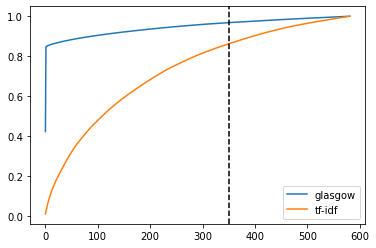

In [8]:
xx = np.arange(len(crf_tfidf))

fig, ax = plt.subplots()
plt.plot(xx,crf_glasgow, label = "glasgow")
plt.plot(xx,crf_tfidf, label = "tf-idf")
# plt.xscale("log")
plt.axvline(350, c="k", linestyle = "--")
plt.legend()

In [9]:
def get_dtm_matrix(twm, n_top):
    X = twm.values[:,:]
    # print(f'X shape: {X.shape}... ntop: {n_top}')
    probs = np.mean(X, axis = 0) 
    probs = pd.DataFrame({"Probs":probs})
    probs = probs.sort_values(by = "Probs", ascending=False)
    # display(probs)

    top_words = probs.index[:n_top]
    # print(top_words.shape)
    twm = twm[twm.columns[top_words]]
    # print(top_words)
    # display(twm)
    
    return twm.mask(twm > 0,1)
 

In [10]:
twm_tfidf_top = get_dtm_matrix(twm_tfidf, n_top = 350)
twm_glasgow_top = get_dtm_matrix(twm_glasgow, n_top = 350)

In [11]:
def calculate_metrics(df,mop):    
    print(mop.shape)
    X, y = mop.values, df["class"].values    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for name_clf, clf in zip(["NAIVE BAYES","SVM"],[GaussianNB(),SVC()]):        
        clf.fit(X, y)
        y_pred = clf.predict(X_test)
        """ 
        -----   Metrics  -----
        """   
        acc = accuracy_score(y_test, y_pred)
        prf = precision_recall_fscore_support(y_test, y_pred,zero_division=0.0)
        pre, spe, sen, f1s = prf[0][1], prf[1][0], prf[1][1], prf[2][1]

        metrics_df = pd.DataFrame({'Recall': [sen],                    
                            'Precision': [pre],
                            'Accuracy': [acc],
                            'F1-Score': [f1s]})
        print(f"Results using: {name_clf}'")            
        display(metrics_df)

In [12]:
calculate_metrics(df,twm_tfidf_top)

calculate_metrics(df,twm_glasgow_top)

(100, 350)
Results using: NAIVE BAYES'


,Recall,Precision,Accuracy,F1-Score
0,1.0,1.0,1.0,1.0


Results using: SVM'


,Recall,Precision,Accuracy,F1-Score
0,1.0,1.0,1.0,1.0


(100, 350)
Results using: NAIVE BAYES'


,Recall,Precision,Accuracy,F1-Score
0,1.0,1.0,1.0,1.0


Results using: SVM'


,Recall,Precision,Accuracy,F1-Score
0,1.0,1.0,1.0,1.0


In [16]:
def varying_top(df,mop, ub, step): 
    metrics_df = {"tresh": [], 
                  'Recall': [],                    
                    'Precision': [],
                    'Accuracy': [],
                    'F1-Score': []}
    for i in np.arange(step,ub,step):
        # print(i)
        new_mop = get_dtm_matrix(mop, n_top = i)
    
        # print(new_mop.shape)
        X, y = new_mop.values, df["class"].values    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        # print(X_train.shape)
        clf = SVC()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        """ 
        -----   Metrics  -----
        """   
        acc = accuracy_score(y_test, y_pred)
        prf = precision_recall_fscore_support(y_test, y_pred,zero_division=0.0)
        pre, spe, sen, f1s = prf[0][1], prf[1][0], prf[1][1], prf[2][1]

        metrics_df["tresh"].append(i)
        metrics_df["Recall"].append(sen)
        metrics_df["Precision"].append(pre)
        metrics_df["Accuracy"].append(acc)
        metrics_df["F1-Score"].append(f1s)
    return pd.DataFrame(metrics_df)

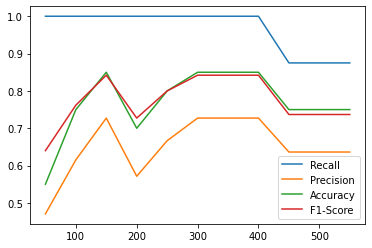

In [17]:
df_results = varying_top(df,twm_tfidf, 600, 50)
for c in df_results.columns:
    if c!="tresh":        
        plt.plot(df_results["tresh"],df_results[c], label = c)
plt.legend()
plt.show()
        

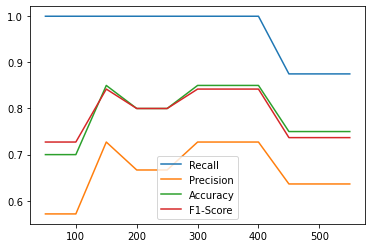

In [18]:
df_results = calculate_metrics(df,twm_glasgow, 600, 50)
for c in df_results.columns:
    if c!="tresh":        
        plt.plot(df_results["tresh"],df_results[c], label = c)
plt.legend()
plt.show()
        